# Behavioral Data Analysis

This Jupyter Notebook organizes and visualizes behavioral data using Python. It includes raster plots, d-prime analysis, learning licks analysis, response time analysis, performance boxplots, and Monte Carlo simulations.

## **Setup**
First, we import the necessary libraries and helper functions.


In [1]:
# Import required modules and custom functions
from Mouse_Data import Mouse_Data
from helpers import *
from visualization import *

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

matplotlib.rcParams.update({'font.size':16, 'font.family':'Times New Roman', 
                            'axes.facecolor':'white' , 'figure.facecolor':'white', 'figure.dpi':100})

# Define root data path
root = 'D:/mStim_data/'

## **Load Data**
We initialize the `Mouse_Data` object, which will be used throughout the analysis.


In [4]:
# Load Mouse Data
data_path = root + 'VPS34/SNA-141498/'
mouse = Mouse_Data(data_path)

# Visualize data and save plots
* Raster Plot 
* D prime (session and trial)
* Lick raster hit and FP
* Response time 
* Hit Percentage

Saving to: D:\mStim_data\VPS34\SNA-141498\analysis\performance_barplot


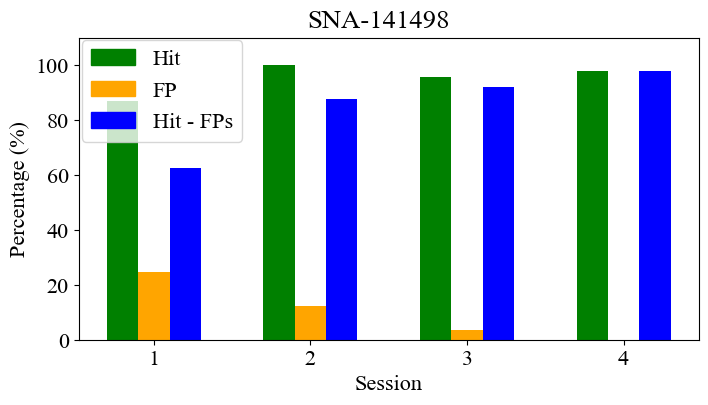

Saving to: D:\mStim_data\VPS34\SNA-141498\analysis\raster
Saving to: D:\mStim_data\VPS34\SNA-141498\analysis\dprime_session


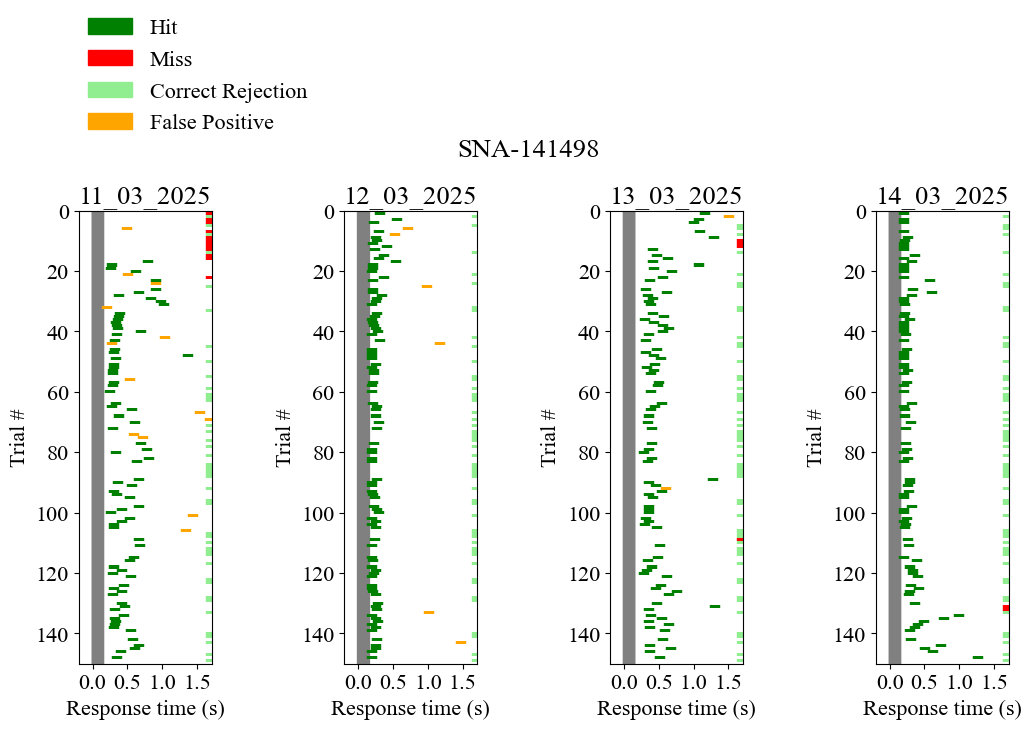

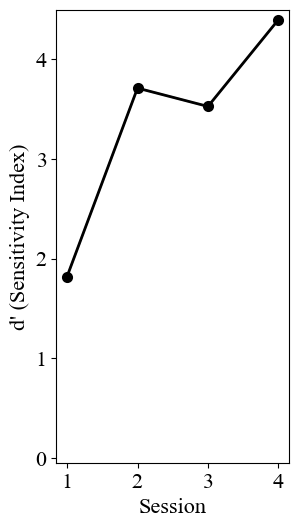

Saving to: D:\mStim_data\VPS34\SNA-141498\analysis\lick_performance


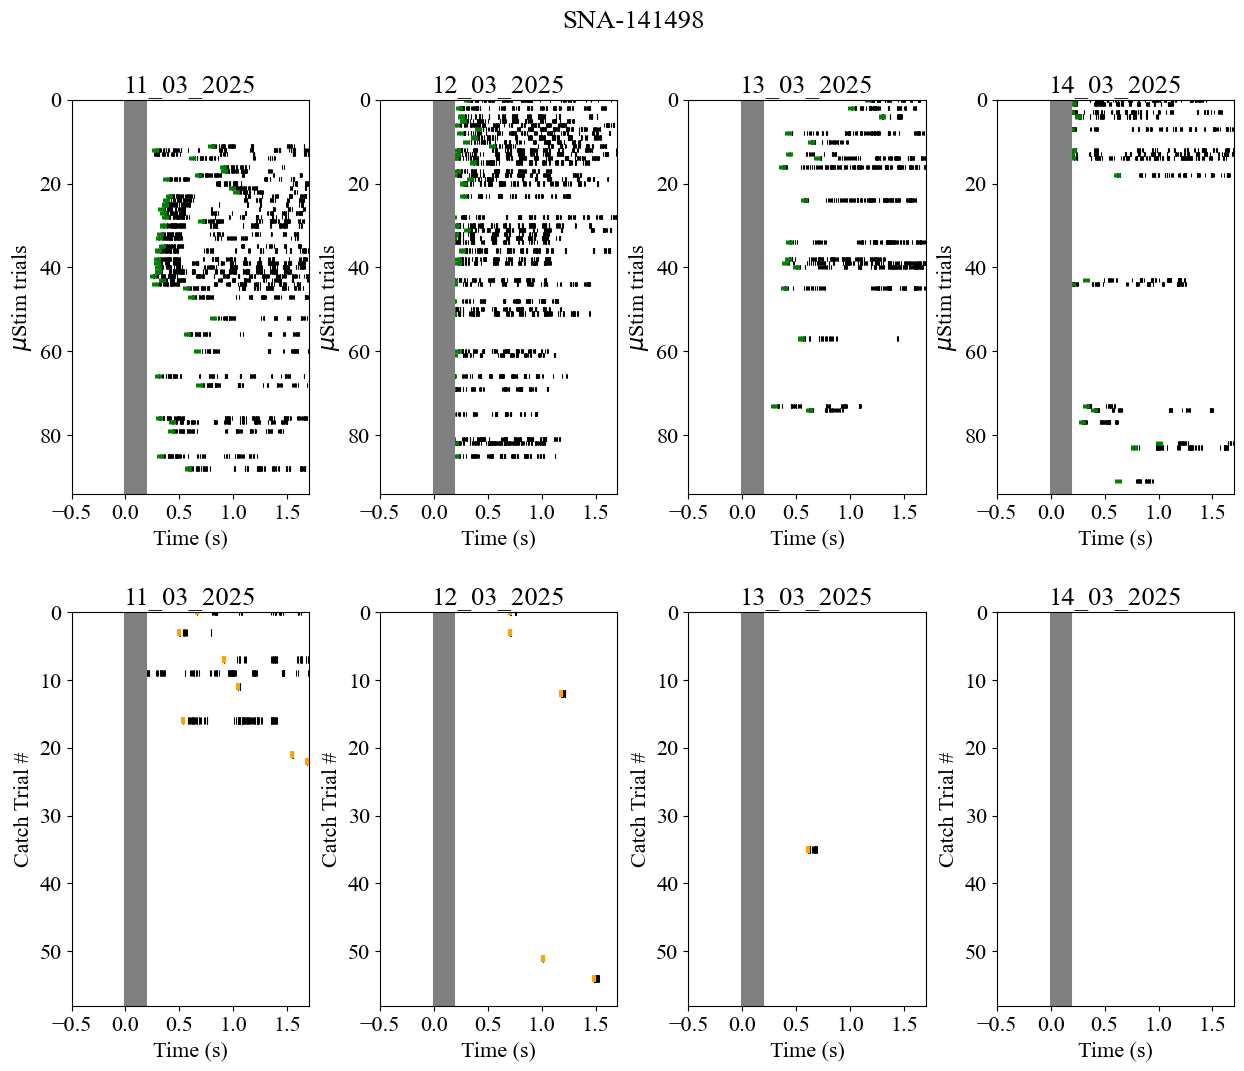

Saving to: D:\mStim_data\VPS34\SNA-141498\analysis\P_Lick


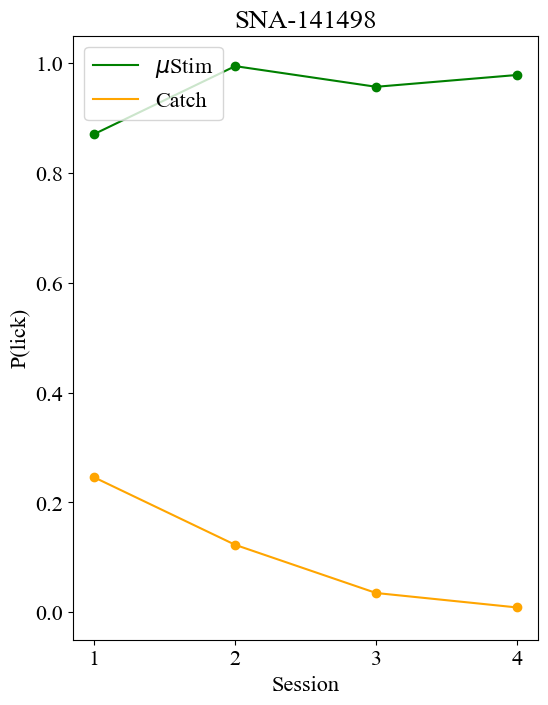

ValueError: x and y must be the same size

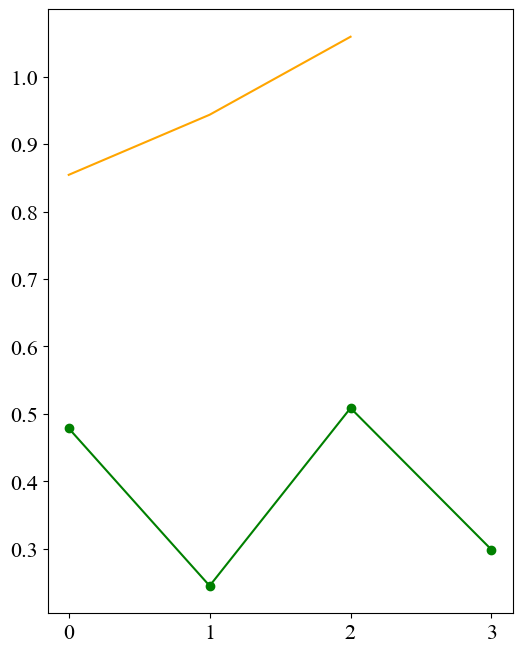

In [5]:
# INDIVIDUAL PLOTS
savePath = data_path + 'analysis/'
plot_performance(mouse, save=savePath + 'performance_barplot')
plot_raster_rt(mouse, save=savePath + 'raster')
plot_d_prime(mouse, save=savePath + 'dprime_session')
plot_lickPerformance(mouse, save=savePath + 'lick_performance')
plot_Plick(mouse, save=savePath+'P_Lick')
plot_RT(mouse, savePath+'RT_session')


In [ ]:
# Calculate and plot the RT during a mStim trial TODO Histogram should be the average occurance of all mice
mouse = ctrl_data[3]
import scipy.stats as stats
RTs_mstim = []
RTs_catch = []
for mouse in ctrl_data:
    session = mouse.sessions[-1]
    session_data = mouse.session_data[session]

    # Differentiate between mStim and catch trials
    mstim = select_trialType(session_data, 'test')
    catch = select_trialType(session_data, 'catch')

    # Now select the hit trials
    mstim = mstim.loc[mstim['success'] == True]
    catch = catch.loc[catch['success'] == True]

    # Now plot a histogram of the first session response times
    RTs_mstim.append(mstim['response_t'])
    RTs_catch.append(catch['response_t'])

# Concat into full dataframe
RTs_mstim = pd.concat(RTs_mstim)
RTs_catch =pd.concat(RTs_catch)
x = np.arange(-1, len(avg_list), 0.1)

# Plot as line NOTE: the line is so high for the 0.2-0.25 ms probably because the animal started licking during the stimulus
fig = plt.figure(figsize=(6,6))
[plt.axvline(i, -1, 3, c='gray', alpha=0.1) for i in np.arange(0, 0.2, 0.001)]

# mStim
density = stats.gaussian_kde(RTs_mstim)
plt.plot(x, density(x), c='blueviolet')

# catch
density = stats.gaussian_kde(RTs_catch)
plt.plot(x, density(x), c='gray')

# Formatting
plt.xlim([-1,2])
plt.ylim(0, 3)
# plt.xlabel('Time from Stimulus Onset (s)')
# plt.ylabel('First Licks (Hz)')
# plt.title('First licks of last session')
plt.show()

# Add SEM line
# avg_list, std_list = get_avg_std_threshold(RTs_mstim, max_sessions=4)

# TODO add legend
# fig.savefig(savePath + 'fLick.svg')

In [ ]:
#FP progression
# False positives over session
# mouse 
def exponential(params, x, y):
    a, b = params
    residuals = y - (a * np.exp(b*x))
    return residuals

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

def fit_sigmoid(x, y):
    p0 = [max(y), np.median(x), 1, min(y)]
    popt, pcov = curve_fit(sigmoid, x,y,p0, maxfev=10000)
    L ,x0, k, b = popt
    y_fit = sigmoid(x, L, x0, k, b)
    return y_fit

def plot_trialPerformance(mouse_data):
    '''docstring'''
    title = mouse_data.id
    n_sessions = len(mouse_data.sessions)
    xticks = np.arange(0, n_sessions, 1)
        
    # Set plot 
    fig, axs = plt.subplots(n_sessions,2, figsize=(10, 10))
    fig.patch.set_facecolor('white')
    
    # Plot the progression of hit trials on the left side
    for n, session in enumerate(mouse.sessions):
        mixData = select_trialType(mouse.all_data[session], 'mixData')
        mscore = []
        mhit = 0
        mtotal = len(mixData)
        for idx, mixTrial in mixData.iterrows():
            if mixTrial['succes'] == True:
                mhit += 1
            mscore.append(mhit/mtotal*100)
        
        # Try to get a fit for mTrials
        x = np.arange(0, len(mscore), 1)
        y = mscore
        y_fit = fit_sigmoid(x, y)
        axs[n,0].plot(y_fit, c='blue')
        axs[n,0].set_ylabel(f'Session {n} \n Hits (%)')
        axs[n,0].set_ylim([0, 100])
        axs[n,0].grid()
        axs[-1,0].set_xlabel('Test Trials')

        
        catchData = select_trialType(mouse.all_data[session], 'catchData')
        total = 0
        FP = 0
        score = []
        total = len(catchData)
        for idx, catchTrial in catchData.iterrows():
            if catchTrial['succes'] == True:
                FP += 1
            score.append((FP/total)*100)
        
        # Try to get a fit
        x = np.arange(0, len(score), 1)
        y = score
        y_fit = fit_sigmoid(x, y)
        
        axs[n,1].plot(y_fit, c='red')
        axs[n,1].set_ylabel('False Positives (%)')
        axs[n,1].set_ylim([0, 30])
        axs[n,1].grid()
        axs[-1,1].set_xlabel('Catch Trials')
        

    fig.suptitle(title, y=.925)  
    plt.show()
    return

mice = []
for ID in mouseIDs:
    print(ID)
    mouse = Mouse_Data(path+ID)
    mice.append(mouse)
    plot_trialPerformance(mouse)



In [ ]:
#OR
''' Now we try to get determine if the FP% decreases over the sessions '''
# Select the dataframe of a single session
mouse = mice[0]

def plot_falsePositives(mouse_data, max_n=10, whiskey_n=0):
    '''docstring'''
    # Get some figure basics and set plot
    title = mouse_data.id
    n_sessions = len(mouse_data.sessions)
    fig = plt.figure(figsize=(16,6))
#     fig.patch.set_facecolor('white')
    colors = ['red', 'orange', 'green']
    FP_dict = {}
    
    # Go through sessions and determine FP score for each trial
    max_length = []
    for n_sesh, session in enumerate(mouse.sessions):
        data = mouse.all_data[session]

        # Lets get all the catchtrial data
        catchData = select_trialType(data, 'catchData')
        max_length.append(len(catchData))
        
        # Create an empty list to keep updating the score on
        FP_score = []
        FP_queue = Queue(maxsize=max_n)
        FP_avg = []
        pastTrials, hits = [whiskey_n,whiskey_n]
        i = 0
        for _, trial in catchData.iterrows():
            i += 1
            pastTrials += 1

            # Check if it was a hit or not    
            if trial['succes']:
                hits += 1
            score = (hits/pastTrials)*100
#             relative_pastTrials = (pastTrials/len(catchData))*100
#             score = score/pastTrials
            FP_score.append(score)

            # Drop as soon as the queue reaches max length
            if i >= max_n:
                FP_queue.get()
            FP_queue.put(score)
            FP_avg.append(np.mean(FP_queue.queue)) 
        FP_dict[n_sesh] = FP_avg
        # FP(%) over trials
#         plt.plot(FP_avg, label=session, c=colors[n_sesh])

        # FP(%) over trial (%)
#         plt.plot(np.linspace(0, 100,len(FP_avg)), FP_avg, label=session, c=colors[n_sesh])

        # Whiskey method 
        FP_avg = FP_avg[whiskey_n:]
        plt.plot(np.linspace(0, 100,len(FP_avg)), FP_avg, label=session, c=colors[n_sesh])
        
    plt.legend()
    plt.title(f'Progression of False Positives during the sessions of: {title}')
    plt.ylabel('FP (%)')
    plt.xlabel('Completed catch trials (%)')
#     plt.xlabel('Catch trial #')
#     plt.xlim([max_n, len(catchData)])
#     plt.xticks(np.arange(0, np.max(max_length), 20))
    plt.show()
    return FP_dict

c = ['red', 'orange', 'green']
for n, mouse in enumerate(mice):
    FP_dict = plot_falsePositives(mouse, whiskey_n=10) #NOTE THAT THERE ARE 20 misstrails added!
    
    # For every session calculate & plot NORMALIZED AUC
    for n_sesh in FP_dict.keys():
        AUC = np.sum(FP_dict[n_sesh])/len(FP_dict[n_sesh])
        plt.bar(n_sesh, AUC, color=c[n_sesh])
    plt.xlabel('Session')
    plt.ylabel('Normalized AUC of FP(%)')
    plt.ylim([0, 55])
    plt.title(mouse.id)
    plt.show()    
    

# Determine learning moment



## **Monte Carlo Simulation**
This section runs a Monte Carlo simulation to estimate the probability of early learning.


In [ ]:
def Monte_Carlo(sample, threshold, num_simulations=100000, save=False, save_path='.'):
    simulation_results = [np.mean(np.random.choice(sample, size=100, replace=True) <= threshold) for _ in range(num_simulations)]
    probability = np.mean(simulation_results)

    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(simulation_results, bins=40, density=True, alpha=0.7, color='blue', label='Random')
    plt.xlabel('Proportion of Animals Learned within first 30 trials')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.show()

    if save:
        fig.savefig(f"{save_path}/MonteCarlo.png", dpi=300)

    return probability

start_threshold = 30
prob = Monte_Carlo([150, 30, 10, 45, 150, 40, 10, 10, 70, 30], start_threshold, save=True, save_path='.')
